# Data Collection

OpenDatasets is a module which is used to extract datasets frmo a particular sites into the runtime

In [62]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import tensorflow as tf
import os,glob,sys
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from collections import Counter
import numpy as np
import pandas as pd

# sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# keras modules
from keras.models import Sequential, Model
from keras.layers import (
    Convolution2D,
    GlobalAveragePooling2D,
    Conv2D, MaxPooling2D,
    ZeroPadding2D,
    MaxPooling2D,
    MaxPooling2D,
    Activation,
    Dropout,
    BatchNormalization,
    Flatten,
    Dense
)

In [64]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


To get your kaggle username you can go to your kaggle account and click generate key, a json file will be created which will contain your username and key. 

<u>NOTE:</u> We don't have to generate the key every time. We can use the same key multiple times although its note advised,. 

In [ ]:
import opendatasets as od

'''
Your Kaggle username: copy + paste your key

Your Kaggle Key: copy + paste your key
'''

od.download(
	"https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection")


# Data Preprocessing

Collect the download location of your 'brain-mri-images-for-brain-tumor-detection' folder which was downloaded now using opendatasets. Since this project was did in google colab you can use this respective location.

Next we try to seperate x into x and y variables and convert all images into a 224 x 224 size image and also convert them to grayscale.

In [113]:
os.chdir('/content/brain-mri-images-for-brain-tumor-detection/yes')
X = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      gray = cv2.resize(img,(224,224) , interpolation=cv2.INTER_AREA)
      X.append(gray)
      y.append((i[0:1]))
os.chdir('/content/brain-mri-images-for-brain-tumor-detection/no')
for i in tqdm(os.listdir()):
    try:
        img = cv2.imread(i)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(img,(224,224) , interpolation=cv2.INTER_AREA)
        X.append(gray)
        y.append('N')
    except:
        pass        
Counter(y).values()

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

dict_values([155, 98])

From the above computer vision processing we can deduce that there are 155 Yes images and 98 No images being processed. Now lets see a sample of the very 1st four images to see whether all the images are properly processed.

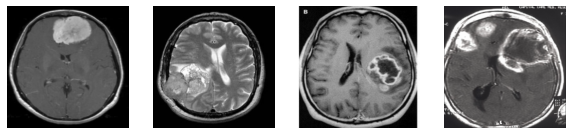

In [114]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


Interpretation:-

224, 224, 3 -> row_pixels, col_pixels, 3-color scale (RGB which are all grayscale mapped)

Now we have have to label encode Yes and No into 0s and 1s and get all the X and y values into an array format.

In [116]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

In [118]:
# 80% -> train and 20% -> test

print("X_train Shape: ", X_train.shape) 
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

X_train Shape:  (202, 224, 224, 3)
X_test Shape:  (51, 224, 224, 3)
y_train Shape:  (202, 2)
y_test Shape:  (51, 2)


# Data Processing

## Using Dense and Sequential in keras (ANN)

In [133]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

We are adding 3 layers technically, the first layer Flatten() is to just correct the shape sizes everytime the input vector is passed. Then we have 2 layers of 32 class Relu and 10 class Relu respectively and at the end 2 class softmax for the classification

In [134]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(32, activation = tf.keras.activations.relu))
model.add(Dense(10, activation = tf.keras.activations.relu))
model.add(Dense(2, activation = tf.keras.activations.softmax))

In [135]:
len(model.layers)

4

In [136]:
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(0.001), metrics = ['mae', 'mse'])

In [137]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 150528)            0         
                                                                 
 dense_39 (Dense)            (None, 32)                4816928   
                                                                 
 dense_40 (Dense)            (None, 10)                330       
                                                                 
 dense_41 (Dense)            (None, 2)                 22        
                                                                 
Total params: 4,817,280
Trainable params: 4,817,280
Non-trainable params: 0
_________________________________________________________________


In [138]:
history = model.fit(X_train,y_train,
                    epochs=50, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0
        )
# tf.expand_dims(X_train, axis=-1)

Epoch 1/50
7/7 [==============================] - 1s 113ms/step - loss: 0.6485 - mae: 0.6485 - mse: 0.6485 - val_loss: 0.5294 - val_mae: 0.5294 - val_mse: 0.5294
Epoch 2/50
7/7 [==============================] - 1s 93ms/step - loss: 0.6337 - mae: 0.6337 - mse: 0.6337 - val_loss: 0.5294 - val_mae: 0.5294 - val_mse: 0.5294
Epoch 3/50
7/7 [==============================] - 1s 92ms/step - loss: 0.6337 - mae: 0.6337 - mse: 0.6337 - val_loss: 0.5294 - val_mae: 0.5294 - val_mse: 0.5294
Epoch 4/50
7/7 [==============================] - 1s 79ms/step - loss: 0.6337 - mae: 0.6337 - mse: 0.6337 - val_loss: 0.5294 - val_mae: 0.5294 - val_mse: 0.5294
Epoch 5/50
7/7 [==============================] - 1s 86ms/step - loss: 0.6337 - mae: 0.6337 - mse: 0.6337 - val_loss: 0.5294 - val_mae: 0.5294 - val_mse: 0.5294
Epoch 6/50
7/7 [==============================] - 1s 87ms/step - loss: 0.6337 - mae: 0.6337 - mse: 0.6337 - val_loss: 0.5294 - val_mae: 0.5294 - val_mse: 0.5294
Epoch 7/50
7/7 [=================

In [139]:
history = pd.DataFrame(history.history)

In [140]:
history.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,0.648515,0.648515,0.648515,0.529412,0.529412,0.529412
1,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
2,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
3,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
4,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412


In [141]:
history.tail()

,loss,mae,mse,val_loss,val_mae,val_mse
45,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
46,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
47,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
48,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412
49,0.633663,0.633663,0.633663,0.529412,0.529412,0.529412


In [142]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 20ms/step


In [143]:
pd.DataFrame(list(zip(y_test,y_pred)), columns = ['Actual Values', 'Predicted Values'])

,Actual Values,Predicted Values
0,"[1.0, 0.0]","[0.99999994, 0.0]"
1,"[0.0, 1.0]","[0.99999994, 0.0]"
2,"[0.0, 1.0]","[0.99999994, 0.0]"
3,"[1.0, 0.0]","[0.99999994, 0.0]"
4,"[0.0, 1.0]","[0.99999994, 0.0]"
5,"[1.0, 0.0]","[0.99999994, 0.0]"
6,"[1.0, 0.0]","[0.99999994, 0.0]"
7,"[1.0, 0.0]","[0.99999994, 0.0]"
8,"[0.0, 1.0]","[0.99999994, 0.0]"
9,"[0.0, 1.0]","[0.99999994, 0.0]"


In [144]:
r2_score(y_test, y_pred)

-1.1249998355180972

In [145]:
loss, mae, mse = model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 19ms/step - loss: 0.5294 - mae: 0.5294 - mse: 0.5294


## Using InceptionV3 pre-trained model (CNN)

In [146]:
from keras.applications import InceptionV3 #vgg16

img_rows, img_cols = 224, 224

inception = InceptionV3(weights = 'imagenet',
                        include_top = False,
                        input_shape = (img_rows, img_cols, 3)) # vgg = vgg16.VGG16()

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in inception.layers: #vgg.;ayers
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(inception.layers): # vgg.layers
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

In [147]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [148]:
num_classes = 2

FC_Head = lw(inception, num_classes)

model = Model(inputs = inception.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [149]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [150]:
history = model.fit(X_train,y_train,
                    epochs=5, 
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
7/7 [==============================] - 40s 5s/step - loss: 43.4414 - accuracy: 0.5248 - val_loss: 18.1833 - val_accuracy: 0.4706
Epoch 2/5
7/7 [==============================] - 36s 5s/step - loss: 12.5957 - accuracy: 0.5396 - val_loss: 2.2387 - val_accuracy: 0.4706
Epoch 3/5
7/7 [==============================] - 38s 6s/step - loss: 1.8894 - accuracy: 0.5792 - val_loss: 1.7349 - val_accuracy: 0.6078
Epoch 4/5
7/7 [==============================] - 34s 5s/step - loss: 0.8167 - accuracy: 0.7574 - val_loss: 0.7592 - val_accuracy: 0.6471
Epoch 5/5
7/7 [==============================] - 36s 5s/step - loss: 0.6873 - accuracy: 0.7624 - val_loss: 0.7211 - val_accuracy: 0.6667


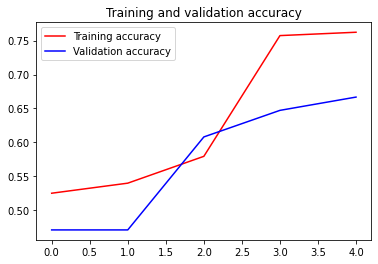

<Figure size 432x288 with 0 Axes>

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()